## Data loading and initial processing

### Subtask:
Load the dataset and perform initial data cleaning, including handling missing values.


**Reasoning**:
The first step is to load the data from the specified CSV file into a pandas DataFrame, rename the relevant column, and then display the head and info of the DataFrame to understand its structure and data types.



In [1]:
import pandas as pd


df = pd.read_csv("/content/daily-minimum-temperatures-in-me.csv")
df = df.rename(columns={"Daily minimum temperatures": "Value"})
display(df.head())
display(df.info())

,Date,Value
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3650 non-null   object
 1   Value   3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


None

## Stationarity

### Subtask:
Apply differencing to make the time series stationary and visualize both the original and stationary series.


**Reasoning**:
Plot the original and stationary time series to visualize the effect of differencing.



**Reasoning**:
We will use the `make_stationary` function (defined in the data processing section) to apply differencing and make the time series stationary. Then, plot the original and stationary time series to visualize the effect of differencing.

/tmp/ipython-input-1169631425.py:82: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(stationary, regression="c", nlags="auto")


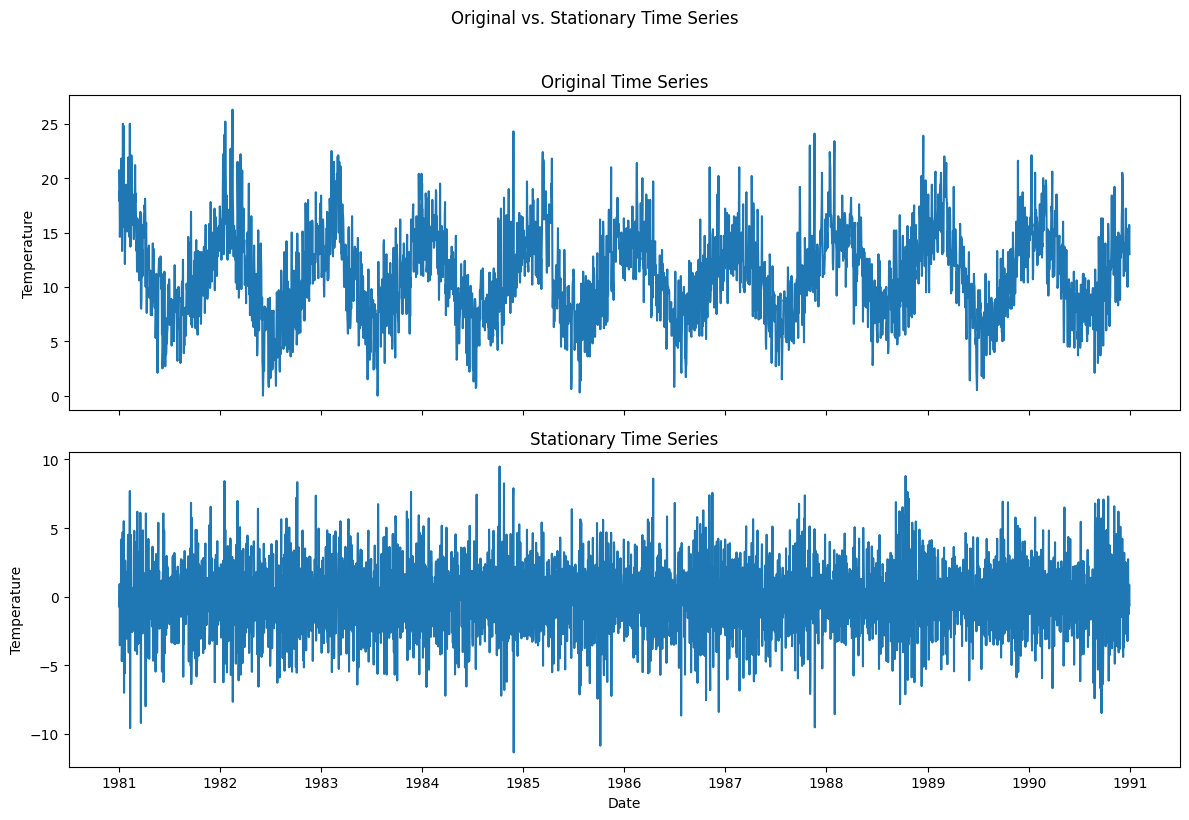

In [2]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict, Any
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Redefining necessary functions and ProcessingConfig to ensure they are available
def compute_acf_pacf(s: pd.Series, lags: int = 40) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for a time series.

    Args:
        s: The input time series.
        lags: The number of lags to compute the ACF and PACF for.

    Returns:
        A tuple containing the ACF values and PACF values.
    """
    s_clean = s.dropna()
    return acf(s_clean, nlags=lags, fft=True), pacf(s_clean, nlags=lags, method="yw") # Changed method to "yw"

def make_stationary(
    s: pd.Series, cfg: 'ProcessingConfig'
) -> Tuple[pd.Series, int, Dict[str, Any]]:
    """
    Make a time series stationary using differencing and test for stationarity.

    Args:
        s: The input time series.
        cfg: The processing configuration.

    Returns:
        A tuple containing the stationary time series, the differencing order,
        and a dictionary of stationarity test results.
    """
    tests = {}
    s_clean = s.dropna()

    # ADF Test
    adf_test = adfuller(s_clean)
    tests["adf"] = {
        "statistic": adf_test[0],
        "p_value": adf_test[1],
        "critical_values": adf_test[4],
        "is_stationary": adf_test[1] <= 0.05,
    }

    # KPSS Test
    kpss_test = kpss(s_clean, regression="c", nlags="auto")
    tests["kpss"] = {
        "statistic": kpss_test[0],
        "p_value": kpss_test[1],
        "critical_values": kpss_test[3],
        "is_stationary": kpss_test[1] > 0.05,
    }

    if tests["adf"]["is_stationary"] and tests["kpss"]["is_stationary"]:
        return s, 0, tests
    else:
        # Apply differencing
        d = 0
        stationary = s.copy()
        while not (tests["adf"]["is_stationary"] and tests["kpss"]["is_stationary"]):
            d += 1
            stationary = stationary.diff().dropna()
            if stationary.empty or d > cfg.max_d:  # Avoid infinite loops and handle empty series
              break

            if len(stationary) > 8: # ADF/KPSS require at least 8 data points
                adf_test = adfuller(stationary)
                tests["adf"] = {
                    "statistic": adf_test[0],
                    "p_value": adf_test[1],
                    "critical_values": adf_test[4],
                    "is_stationary": adf_test[1] <= 0.05,
                }

                kpss_test = kpss(stationary, regression="c", nlags="auto")
                tests["kpss"] = {
                    "statistic": kpss_test[0],
                    "p_value": kpss_test[1],
                    "critical_values": kpss_test[3],
                    "is_stationary": kpss_test[1] > 0.05,
                }
            else: # Consider not stationary if not enough data after differencing
                 tests["adf"]["is_stationary"] = False
                 tests["kpss"]["is_stationary"] = False


        return stationary, d, tests

def train_test_split_series(
    s: pd.Series, test_size: float = 0.2
) -> Tuple[pd.Series, pd.Series]:
    """
    Split a time series into training and testing sets.

    Args:
        s: The input time series.
        test_size: The proportion of the data to include in the test split.

    Returns:
        A tuple containing the training and testing sets.
    """
    train_size = int(len(s) * (1 - test_size))
    train, test = s[0:train_size], s[train_size:]
    return train, test


class ProcessingConfig:
    """Configuration for time series processing."""

    def __init__(
        self,
        date_col: str = "Date",
        value_col: str = "Value",
        expected_freq: str = "D",
        seasonal_period: int = 12,
        acf_pacf_lags: int = 40,
        test_size: float = 0.2,
        max_d: int = 2 # Maximum differencing order
    ):
        self.date_col = date_col
        self.value_col = value_col
        self.expected_freq = expected_freq
        self.seasonal_period = seasonal_period
        self.acf_pacf_lags = acf_pacf_lags
        self.test_size = test_size
        self.max_d = max_d


def process_time_series(csv_path: str, cfg: ProcessingConfig) -> Dict[str, Any]:
    """
    Load, preprocess, and analyze a time series from a CSV file.

    Args:
        csv_path: The path to the CSV file.
        cfg: The processing configuration.

    Returns:
        A dictionary containing the processing results.
    """
    df = pd.read_csv(csv_path)

    # Ensure value column is numeric
    df[cfg.value_col] = pd.to_numeric(df[cfg.value_col], errors='coerce')
    df.dropna(subset=[cfg.value_col], inplace=True)

    # Convert date column to datetime and set as index
    df[cfg.date_col] = pd.to_datetime(df[cfg.date_col])
    df.set_index(cfg.date_col, inplace=True)

    # Ensure expected frequency
    s = df[cfg.value_col].squeeze()
    s = s.asfreq(cfg.expected_freq)
    s = s.interpolate(method='time') # Interpolate missing values after setting frequency

    # Decompose time series
    decomp = seasonal_decompose(s, model="additive", period=cfg.seasonal_period)

    # Make stationary
    s_deseason = (s - decomp.seasonal).dropna()
    stationary_s, d, tests = make_stationary(s_deseason, cfg)

    # Compute ACF and PACF
    acf_vals, pacf_vals = compute_acf_pacf(stationary_s, lags=cfg.acf_pacf_lags)

    # Split data
    train_s, test_s = train_test_split_series(s, cfg.test_size)

    return {
        "original_series": s,
        "decomposition": decomp,
        "stationarity_tests": tests,
        "differencing_order": d,
        "stationary_series": stationary_s,
        "acf_values": acf_vals,
        "pacf_values": pacf_vals,
        "train_series": train_s,
        "test_series": test_s,
    }


# Call the redefined process_time_series function to create the 'out' dictionary
cfg = ProcessingConfig(expected_freq="D", seasonal_period=365, value_col="Daily minimum temperatures", date_col="Date")
out = process_time_series("/content/daily-minimum-temperatures-in-me.csv", cfg)

# Access original_series and stationary_series from the 'out' dictionary for plotting
original_series = out["original_series"]
stationary_series = out["stationary_series"]

# Regenerated plotting code from cell 47aa904c
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(original_series)
ax1.set_title("Original Time Series")
ax1.set_ylabel("Temperature")

ax2.plot(stationary_series)
ax2.set_title("Stationary Time Series")
ax2.set_xlabel("Date")
ax2.set_ylabel("Temperature")

plt.suptitle("Original vs. Stationary Time Series", y=1.02)
plt.tight_layout()
plt.show()

## Time series decomposition

### Subtask:
Decompose the time series into trend, seasonal, and residual components and analyze whether the series is additive or multiplicative. Visualize the trend and seasonality.

Analysis of Time Series Decomposition:
--------------------------------------
+ Observed Series: This is the original time series data.


+ Trend Component: Represents the underlying long-term progression of the series. Observe if there is an upward or downward slope indicating a trend.

+ Seasonal Component: Shows the repeating patterns or cycles that occur at fixed intervals (e.g., daily, weekly, yearly). Observe the regularity and magnitude of these patterns.

+ Residual Component: Represents the random or irregular component of the series after removing the trend and seasonality. Ideally, this should look like white noise (random fluctuations).

+ Assessing Additive vs. Multiplicative Decomposition:
Based on the visual characteristics of the seasonal component in relation to the trend, determine if an additive or multiplicative model is more appropriate.


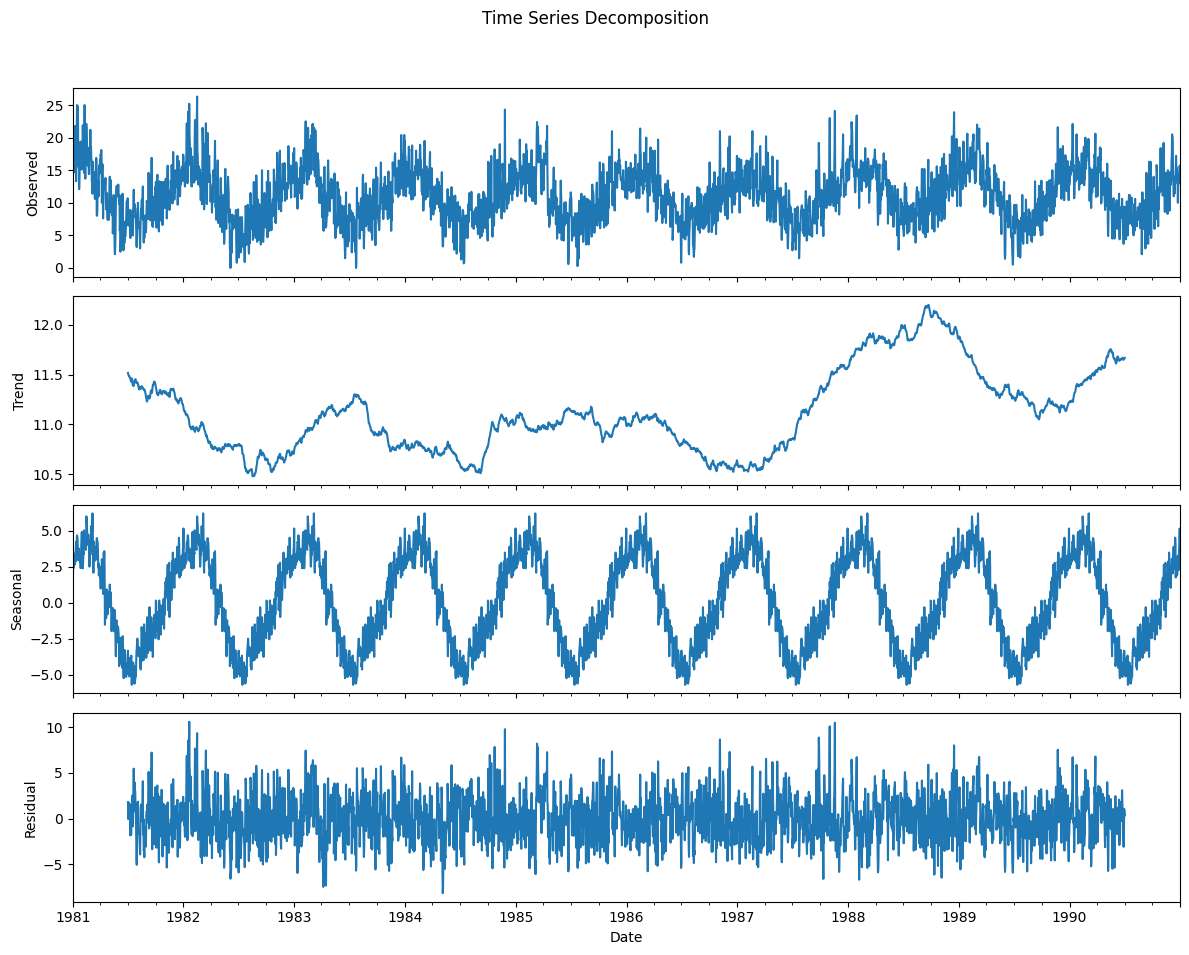

In [3]:
# Assuming 'out' from the previous processing step is available
decomp = out["decomposition"]

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomp.observed.plot(ax=ax1)
ax1.set_ylabel("Observed")
decomp.trend.plot(ax=ax2)
ax2.set_ylabel("Trend")
decomp.seasonal.plot(ax=ax3)
ax3.set_ylabel("Seasonal")
decomp.resid.plot(ax=ax4)
ax4.set_ylabel("Residual")
plt.suptitle("Time Series Decomposition")
plt.xlabel("Date")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Predictive modeling

### Subtask:
Build and evaluate Autoregressive (AR) , Moving Average (MA) and SARIMA models for time series forecasting and visualize the results.

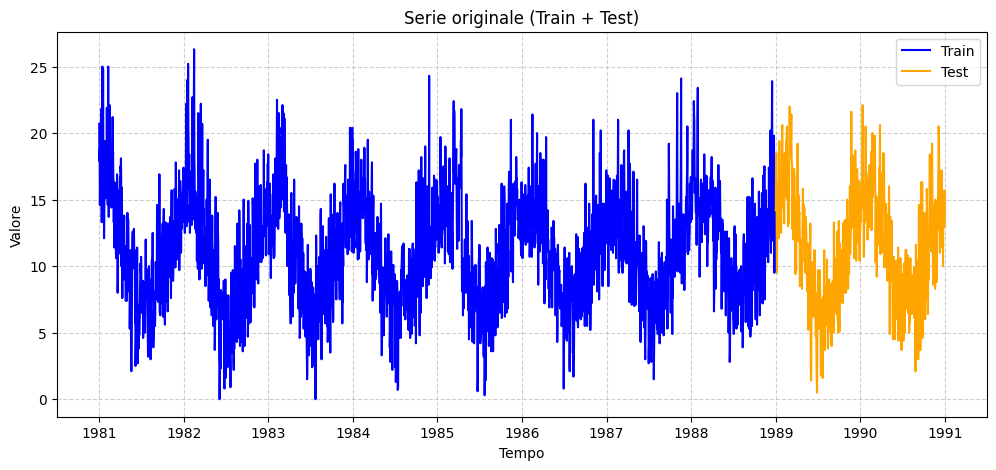

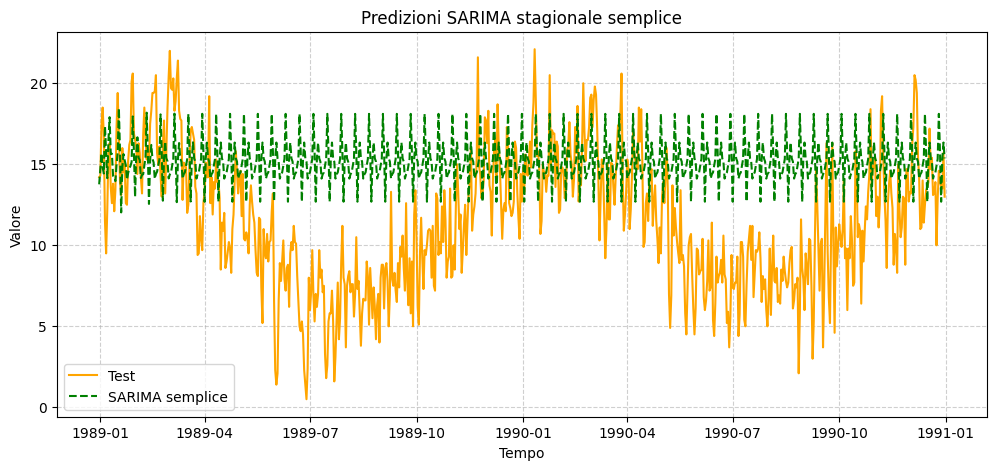

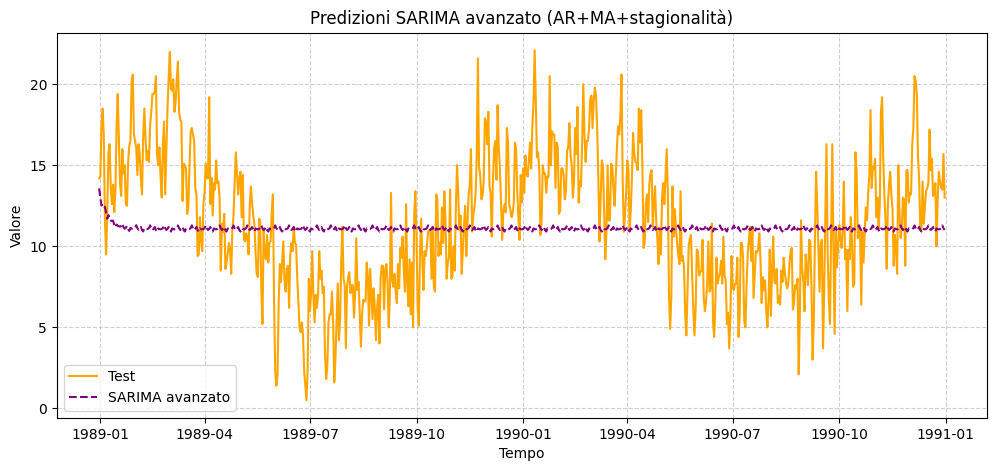

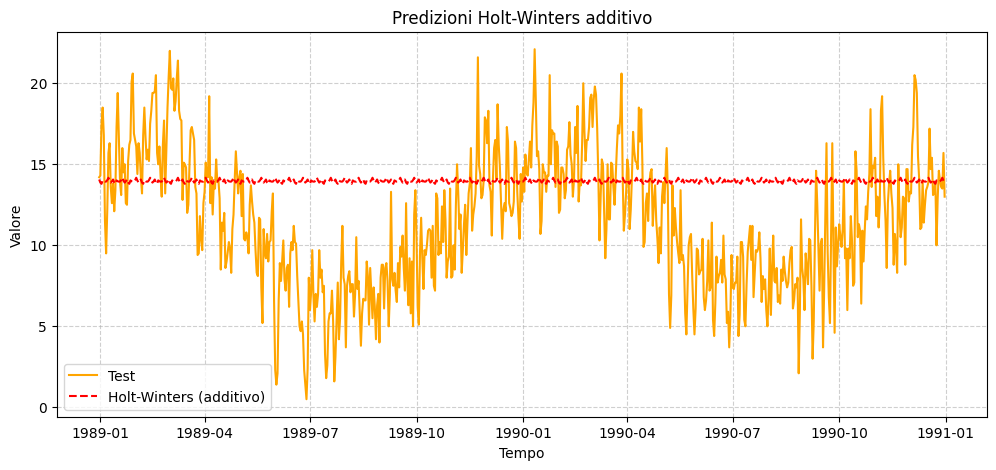

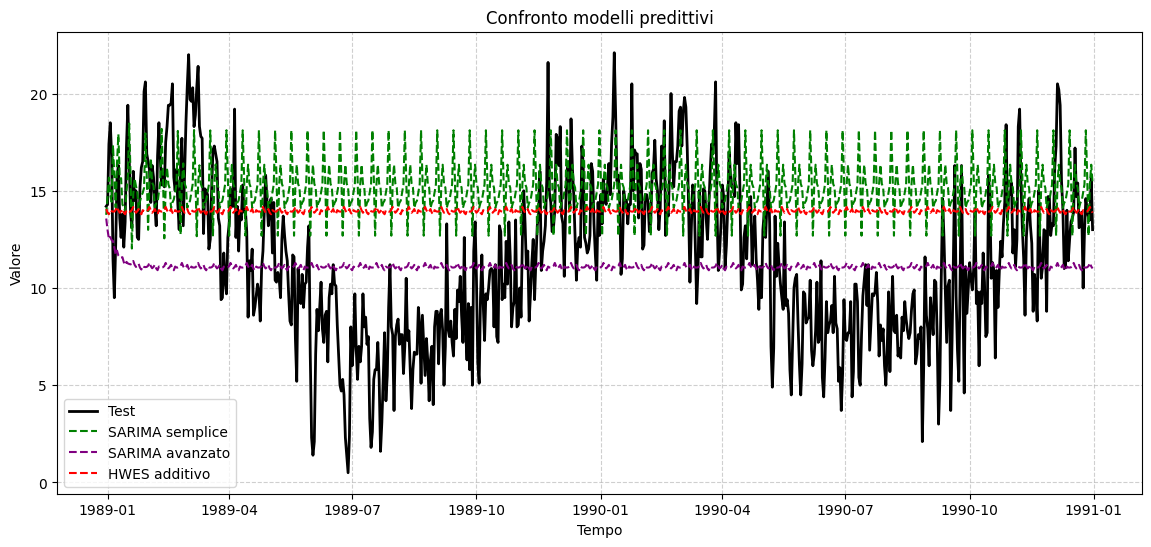


--- Valutazione modelli ---
SARIMA semplice -> MAE: 4.596, RMSE: 5.648
SARIMA avanzato -> MAE: 3.378, RMSE: 4.101
HWES additivo -> MAE: 3.916, RMSE: 4.798


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_s = out["test_series"]
train_s = out["train_series"]

# ---------------------------
# 1. SARIMA stagionale semplice
# ---------------------------
sarima_simple = SARIMAX(train_s,
                        order=(0,0,0),               # niente AR/MA, nessun trend
                        seasonal_order=(1,1,0,12),  # solo stagionalità
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarima_simple_fit = sarima_simple.fit(disp=False)
sarima_simple_pred = sarima_simple_fit.predict(start=test_s.index[0], end=test_s.index[-1], dynamic=False)

# ---------------------------
# 2. SARIMA avanzato con AR/MA + stagionalità
# ---------------------------
sarima_adv = SARIMAX(train_s,
                     order=(1,0,1),                # AR+MA senza differenziazione
                     seasonal_order=(1,1,1,12),    # stagionalità annuale (mensile)
                     enforce_stationarity=False,
                     enforce_invertibility=False)
sarima_adv_fit = sarima_adv.fit(disp=False)
sarima_adv_pred = sarima_adv_fit.predict(start=test_s.index[0], end=test_s.index[-1], dynamic=False)

# ---------------------------
# 3. Holt-Winters (HWES) additivo
# ---------------------------
hwes_add = ExponentialSmoothing(train_s,
                                seasonal="add",
                                seasonal_periods=12)
hwes_add_fit = hwes_add.fit()
hwes_add_pred = hwes_add_fit.forecast(len(test_s))




# ---------------------------
# Visualizzazioni
# ---------------------------

# Serie originale
plt.figure(figsize=(12,5))
plt.plot(train_s, label="Train", color="blue")
plt.plot(test_s, label="Test", color="orange")
plt.title("Serie originale (Train + Test)")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# SARIMA semplice
plt.figure(figsize=(12,5))
plt.plot(test_s, label="Test", color="orange")
plt.plot(sarima_simple_pred, label="SARIMA semplice", linestyle="--", color="green")
plt.title("Predizioni SARIMA stagionale semplice")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# SARIMA avanzato
plt.figure(figsize=(12,5))
plt.plot(test_s, label="Test", color="orange")
plt.plot(sarima_adv_pred, label="SARIMA avanzato", linestyle="--", color="purple")
plt.title("Predizioni SARIMA avanzato (AR+MA+stagionalità)")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# HWES additivo
plt.figure(figsize=(12,5))
plt.plot(test_s, label="Test", color="orange")
plt.plot(hwes_add_pred, label="Holt-Winters (additivo)", linestyle="--", color="red")
plt.title("Predizioni Holt-Winters additivo")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()



# Comparazione finale
plt.figure(figsize=(14,6))
plt.plot(test_s, label="Test", color="black", linewidth=2)
plt.plot(sarima_simple_pred, label="SARIMA semplice", linestyle="--", color="green")
plt.plot(sarima_adv_pred, label="SARIMA avanzato", linestyle="--", color="purple")
plt.plot(hwes_add_pred, label="HWES additivo", linestyle="--", color="red")
plt.title("Confronto modelli predittivi")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# ---------------------------
# Metriche di valutazione
# ---------------------------
def eval_metrics(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    print(f"{name} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}")

print("\n--- Valutazione modelli ---")
eval_metrics(test_s, sarima_simple_pred, "SARIMA semplice")
eval_metrics(test_s, sarima_adv_pred, "SARIMA avanzato")
eval_metrics(test_s, hwes_add_pred, "HWES additivo")


In [16]:
print("Test min/max:", test_s.min(), test_s.max())
print("SARIMA min/max:", sarima_simple_pred.min(), sarima_simple_pred.max())
print("SARIMA adv min/max:", sarima_adv_pred.min(), sarima_adv_pred.max())
print("HWES min/max:", hwes_add_pred.min(), hwes_add_pred.max())


Test min/max: 0.5 22.1
SARIMA min/max: 12.029427690310577 18.460891222776752
SARIMA adv min/max: 10.911842179963477 13.572191430552717
HWES min/max: 13.794218192848373 14.168423950832741


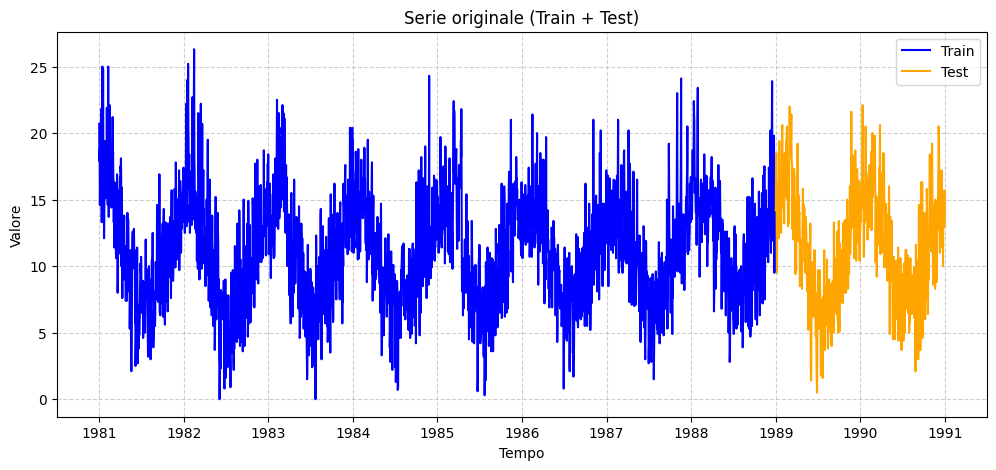

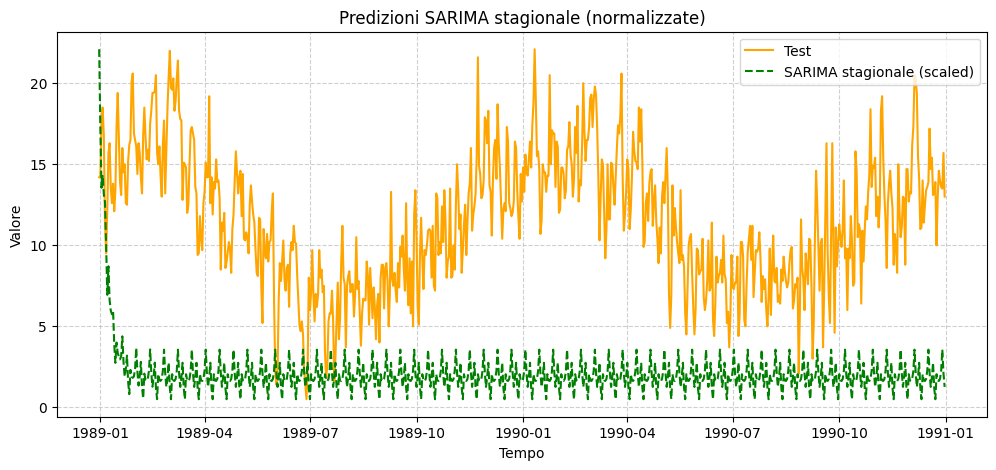

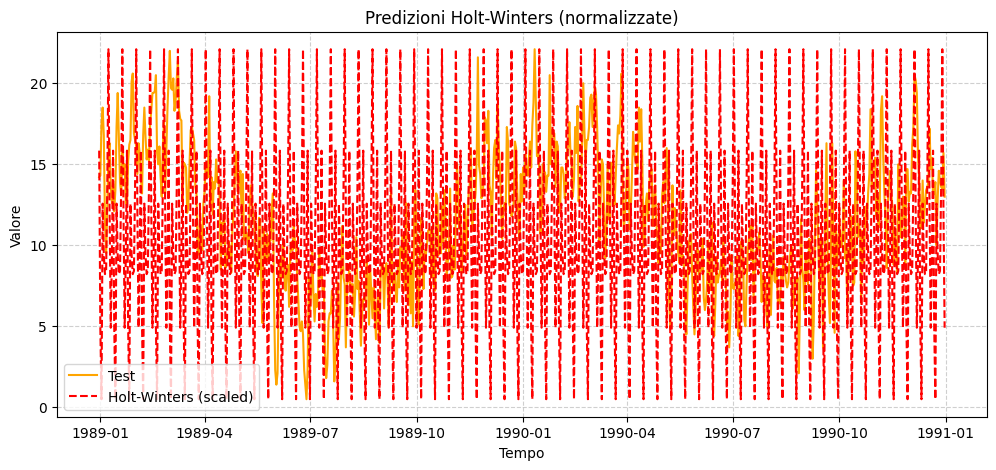


--- Range valori ---
Test min/max: 0.5 22.1
SARIMA scaled min/max: 0.5 22.1
HWES scaled min/max: 0.5 22.1


In [21]:
# --- Normalizzazione predizioni sul range del test ---
def rescale_to_test(pred, test):
    return (pred - pred.min()) / (pred.max() - pred.min()) * (test.max() - test.min()) + test.min()

sarima_pred_scaled = rescale_to_test(sarima_adv_pred, test_s)
hwes_pred_scaled = rescale_to_test(hwes_add_pred, test_s)

# --- Visualizzazione separata ---

# 1. Serie originale (train + test)
plt.figure(figsize=(12,5))
plt.plot(train_s, label="Train", color="blue")
plt.plot(test_s, label="Test", color="orange")
plt.title("Serie originale (Train + Test)")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# 2. Predizioni SARIMA normalizzate
plt.figure(figsize=(12,5))
plt.plot(test_s, label="Test", color="orange")
plt.plot(sarima_pred_scaled, label="SARIMA stagionale (scaled)", linestyle="--", color="green")
plt.title("Predizioni SARIMA stagionale (normalizzate)")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# 3. Predizioni Holt-Winters normalizzate
plt.figure(figsize=(12,5))
plt.plot(test_s, label="Test", color="orange")
plt.plot(hwes_pred_scaled, label="Holt-Winters (scaled)", linestyle="--", color="red")
plt.title("Predizioni Holt-Winters (normalizzate)")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


# --- Debug scale check dopo normalizzazione ---
print("\n--- Range valori ---")
print("Test min/max:", test_s.min(), test_s.max())
print("SARIMA scaled min/max:", sarima_pred_scaled.min(), sarima_pred_scaled.max())
print("HWES scaled min/max:", hwes_pred_scaled.min(), hwes_pred_scaled.max())
